# 【課題】アダマールテスト

```{contents} 目次
---
local: true
---
```

$\newcommand{\ket}[1]{|#1\rangle}$
$\newcommand{\braket}[2]{\langle #1 | #2 \rangle}$

In [1]:
# まずは全てインポート
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

print('notebook ready')

notebook ready


## 問題1: アダマールテストで状態ベクトルを同定する

実習で登場したSWAPテストは、実はアダマールテストという、より一般的な量子回路の構造の一例でした。アダマールテスト回路は以下のような形をしています。

```{image} figs/hadamard_test.png
:alt: hadamard_test
:width: 300px
:align: center
```

図中、ゲート$G$は$H$または$R_x(\pi/2)$、$U$はdataレジスタにかかる任意の回路です。

$G=H$ならば、回路の終状態は

$$
\begin{split}
\ket{\text{final}} & = \frac{1}{2} \left[ (\ket{0} + \ket{1})_{\text{test}} \ket{\psi}_{\text{data}} + (\ket{0} - \ket{1})_{\text{test}} U \ket{\psi}_{\text{data}} \right] \\
& = \frac{1}{2} \left[ \ket{0}_{\text{test}} (\ket{\psi} + U \ket{\psi})_{\text{data}} + \ket{1}_{\text{test}} (\ket{\psi} - U \ket{\psi})_{\text{data}} \right]
\end{split}
$$

なので、testビットを測定して0が得られる確率を$P_0$、1が得られる確率を$P_1$とすると、

$$
\begin{align}
P_0 & = \frac{1}{4} \lVert \ket{\psi} + U \ket{\psi} \rVert_2 = \frac{1}{2} (1 + \mathrm{Re}\braket{\psi}{U \psi}) \\
P_1 & = \frac{1}{4} \lVert \ket{\psi} - U \ket{\psi} \rVert_2 = \frac{1}{2} (1 - \mathrm{Re}\braket{\psi}{U \psi}),
\end{align}
$$

したがって

$$
P_0 - P_1 = \mathrm{Re}\braket{\psi}{U \psi}
$$

となります。

いっぽう、$G = R_x(\pi/2)$ならば、終状態は

$$
\begin{split}
\ket{\text{final}} & = \frac{1}{2} \left[ (\ket{0} + \ket{1})_{\text{test}} \ket{\psi}_{\text{data}} - i (\ket{0} - \ket{1})_{\text{test}} U \ket{\psi}_{\text{data}} \right] \\
& = \frac{1}{2} \left[ \ket{0}_{\text{test}} (\ket{\psi} - i U \ket{\psi})_{\text{data}} + \ket{1}_{\text{test}} (\ket{\psi} + i U \ket{\psi})_{\text{data}} \right]
\end{split}
$$

なので

$$
\begin{align}
P_0 & = \frac{1}{4} \lVert \ket{\psi} - i U \ket{\psi} \rVert_2 = \frac{1}{2} (1 + \mathrm{Im}\braket{\psi}{U \psi}) \\
P_1 & = \frac{1}{4} \lVert \ket{\psi} + i U \ket{\psi} \rVert_2 = \frac{1}{2} (1 - \mathrm{Im}\braket{\psi}{U \psi})
\end{align}
$$

となり、

$$
P_0 - P_1 = \mathrm{Im}\braket{\psi}{U \psi}
$$

が得られます。

アダマールテストを利用すれば、状態$\ket{\psi}$を$\ket{0}$から作る回路$U_{\psi}$が既知のとき、$\ket{\psi}$の計算基底での展開$\sum_k c_k \ket{k}$を振幅の位相情報も含めて推定することができます。そのためには、上でデータレジスタの初期状態を$\ket{0}$、$U$を$U^{-1}_k U_{\psi}$とします。ただし$U_k$は$\ket{0}$から$\ket{k}$を作る回路です。すると、$G=H$と$G=R_x(\pi/2)$とでアダマールテストをすることで、$\braket{0}{U^{-1}_k \psi} = \braket{k}{\psi} = c_k$の実部と虚部がそれぞれ計算できます（最初の等号が成立する証明は、実習の{ref}`inverse_circuit`を参照してください）。これを$0$から$2^n - 1$までの$k$について繰り返せば、$\{c_k\}_k$を完全に求められます。

以下で、既知だけど何か複雑な状態$\ket{\psi}$の状態ベクトルを調べてみましょう。まずは$U_{\psi}$を定義します。

In [2]:
# データレジスタのビット数
data_width = 6

# 状態|ψ>を作る回路
upsi = QuantumCircuit(data_width, name='psi')
upsi.x(0)
upsi.h(2)
upsi.cx(2, 3)
for itarg in range(data_width - 1, -1, -1):
    upsi.h(itarg)
    for ictrl in range(itarg - 1, -1, -1):
        power = ictrl - itarg - 1 + data_width
        upsi.cp((2 ** power) * 2. * np.pi / (2 ** data_width), ictrl, itarg)

for iq in range(data_width // 2):
    upsi.swap(iq, data_width - 1 - iq)

Qiskitでは、`QuantumCircuit`オブジェクトで表される量子回路を、`to_gate()`メソッドで一つのゲートオブジェクトに変換することができます。さらにそのゲートに対して`control(n)`メソッドを用いると、元の回路をn量子ビットで制御する制御ゲートを作ることができます。

In [3]:
upsi_gate = upsi.to_gate()
cupsi_gate = upsi_gate.control(1)

$U^{-1}_k$とその制御ゲート化は$k$の関数として定義しておきます。

In [4]:
def make_cukinv_gate(k):
    uk = QuantumCircuit(data_width, name=f'u_{k}')

    # kの２進数表現を得るために、unpackbitsを利用（他にもいろいろな方法がある）
    # unpackbitsはuint8タイプのアレイを引数に取るので、jをその形に変換してから渡している
    k_bits = np.unpackbits(np.asarray(k, dtype=np.uint8), bitorder='little')
    # k_bitsアレイのうち、ビットが立っているインデックスを得て、それらにXゲートをかける
    for idx in np.nonzero(k_bits)[0]:
        uk.x(idx)

    # 形式上逆回路を作るが、Xの逆操作はXなので、実は全く同一の回路
    ukinv = uk.inverse()

    ukinv_gate = ukinv.to_gate()
    cukinv_gate = ukinv_gate.control(1)

    return cukinv_gate

ゲートオブジェクトは`QuantumCircuit`オブジェクトに`append()`で組み込むことができます。制御ゲートを埋め込む場合は、制御ビットが組み込み先の最初のnビットとなるので、`append()`の`qargs`引数で正しく対応づけします。

次のセルで$k=0$から$2^n-1$までそれぞれ2通りのアダマールテストを行い、$\ket{\psi}$の計算基底展開を求めてください。

In [5]:
reg_data = QuantumRegister(data_width, name='data')
reg_test = QuantumRegister(1, name='test')
creg_test = ClassicalRegister(1)

# 実部用と虚部用の回路をそれぞれリストに入れ、一度にシミュレータに渡す
circuits_re = []
circuits_im = []

ks = np.arange(2 ** data_width)

for k in ks:
    circuit_re = QuantumCircuit(reg_data, reg_test, creg_test)
    circuit_im = QuantumCircuit(reg_data, reg_test, creg_test)

    ##################
    ### EDIT BELOW ###
    ##################

    # 制御ゲートをcircuitに組み込む例
    # circuit.append(cupsi_gate, qargs=([reg_test[0]] + reg_data[:]))

    ##################
    ### EDIT ABOVE ###
    ##################

    circuit_re.measure(reg_test, creg_test)
    circuit_im.measure(reg_test, creg_test)

    circuits_re.append(circuit_re)
    circuits_im.append(circuit_im)

# シミュレータで回路を実行
simulator = AerSimulator()
shots = 10000

circuits_re = transpile(circuits_re, backend=simulator)
circuits_im = transpile(circuits_im, backend=simulator)

counts_list_re = simulator.run(circuits_re, shots=shots).result().get_counts()
counts_list_im = simulator.run(circuits_im, shots=shots).result().get_counts()

# 状態ベクトルアレイ
statevector = np.empty(2 ** data_width, dtype=np.complex128)

for k in ks:
    counts_re = counts_list_re[k]
    counts_im = counts_list_im[k]
    statevector[k] = (counts_re.get('0', 0) - counts_re.get('1', 0)) / shots
    statevector[k] += 1.j * (counts_im.get('0', 0) - counts_im.get('1', 0)) / shots

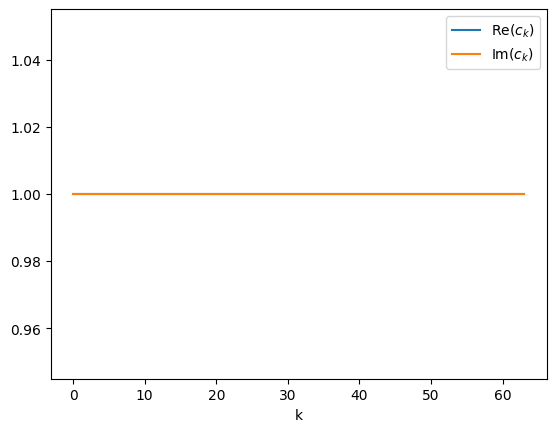

In [6]:
plt.plot(ks, statevector.real, label='Re($c_k$)')
plt.plot(ks, statevector.imag, label='Im($c_k$)')
plt.xlabel('k')
plt.legend();

得られた結果と状態ベクトルシミュレータで計算される状態ベクトルとを比較してみましょう。

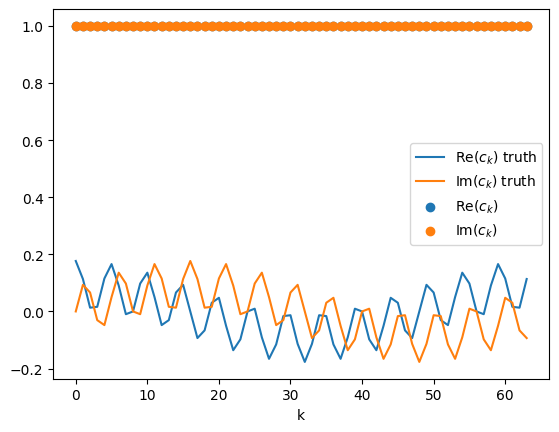

In [7]:
sv_simulator = AerSimulator(method='statevector')

# save_statevectorをくっつけるので元の回路をコピーする
circuit = upsi.copy()
circuit.save_statevector()

circuit = transpile(circuit, backend=sv_simulator)
statevector_truth = np.asarray(sv_simulator.run(circuit).result().data()['statevector'])

plt.plot(ks, statevector_truth.real, label='Re($c_k$) truth')
plt.plot(ks, statevector_truth.imag, label='Im($c_k$) truth')
plt.scatter(ks, statevector.real, label='Re($c_k$)')
plt.scatter(ks, statevector.imag, label='Im($c_k$)')
plt.xlabel('k')
plt.legend();

## 問題2: 符号が反転している基底を見つける

実習で出てきたequal superposition状態

$$
H^{\otimes n} \ket{0} = \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1} \ket{k}
$$

をそのまま測定すると、全ての整数$k$に対応するビット列が等しい確率で現れます。測定でビット列が現れる確率はそのビット列に対応する計算基底の振幅の絶対値自乗で決まるので、重ね合わせにおいてある整数$\tilde{k}$の符号だけ逆転している以下の状態でもやはり全ての整数が確率$1/2^n$で得られます。

$$
\frac{1}{\sqrt{2^n}} \left( \sum_{k \neq \tilde{k}} \ket{k} - \ket{\tilde{k}} \right)
$$

（一般に、全ての計算基底にバラバラに位相因子$e^{i\theta_{k}}$がかかっていても確率は同じです。）

さて、{doc}`後の実習 <grover>`で登場するグローバー探索というアルゴリズムは、上のように一つの計算基底の符号を逆転させるブラックボックス演算子（どの基底かは事前に知られていない）が与えられたときに、符号の反転が起こっている計算基底を効率よく見つけ出すための手法です。グローバー探索を利用すると、例えば$N$個のエントリーのあるデータベースから特定のエントリーを探し出すのに、$\mathcal{O}(\sqrt{N})$回データベースを参照すればいいということがわかっています。

今から考えるのはそのような効率的な方法ではなく、同じようにブラックボックス演算子が与えられたときに、原理的には符号の反転が起こっている基底を見つけることができる、という手法です。そのために振幅の干渉を利用します。

まずは具体性のために$n=3$として、ブラックボックスは$k=5$の符号を反転させるとします。ここでブラックボックスの中身が完全に明かされてしまっていますが、これは実装上の都合で、重要なのは検索アルゴリズムが中身（5）を一切参照しないということです。

後で便利なように、まずはブラックボックスを単体の回路として定義します。

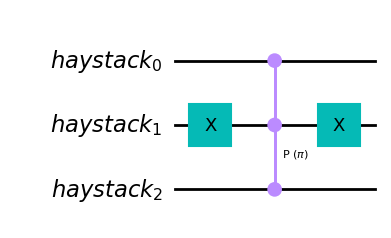

In [8]:
num_qubits = 3
needle = 5

haystack_register = QuantumRegister(num_qubits, name='haystack') # ビット数を指定してレジスタを作る
blackbox_circuit = QuantumCircuit(haystack_register, name='blackbox') # レジスタから回路を作る

# unpackbitsでneedleが二進数のビット列に変換される。それを1から引くことでビット反転
needle_bits = 1 - np.unpackbits(np.asarray(needle, dtype=np.uint8), bitorder='little')[:num_qubits]
for idx in np.nonzero(needle_bits)[0]:
    blackbox_circuit.x(haystack_register[idx])

# レジスタの（0番から）最後から二番目のビットまでで制御し、最後のビットを標的にする
blackbox_circuit.mcp(np.pi, haystack_register[:-1], haystack_register[-1])

# 後片付け
for idx in np.nonzero(needle_bits)[0]:
    blackbox_circuit.x(haystack_register[idx])

blackbox_circuit.draw('mpl')

ここまでは{doc}`circuit_from_scratch`の問題5と同じです。

問題1でやったのと同様、QuantumCircuitオブジェクト全体を一つのゲートのようにみなして、それから制御ゲートを派生させます。

In [9]:
# blackbox_circuitを3量子ビットゲート化
blackbox = blackbox_circuit.to_gate()
# さらにblackboxゲートを1制御+3標的ビットゲート化
cblackbox = blackbox.control(1)

それでは、この制御ブラックボックスゲートを利用して、equal superpositionにある`haystack`レジスタで干渉を起こして、観測で`needle`が識別できるような回路を書いてください。

ヒント：アダマールテストの回路は、量子状態ベクトル同士を足したり引いたりして振幅の干渉を起こさせる回路のテンプレートでもあります。

In [10]:
def make_haystack_needle():
    test_register = QuantumRegister(1, 'test')
    circuit = QuantumCircuit(haystack_register, test_register)

    # equal superpositionを作る（このようにゲート操作のメソッドにレジスタを渡すと、レジスタの各ビットにゲートがかかります。）
    circuit.h(haystack_register)

    ##################
    ### EDIT BELOW ###
    ##################

    #circuit.?

    ##################
    ### EDIT ABOVE ###
    ##################

    circuit.measure_all()

    return circuit

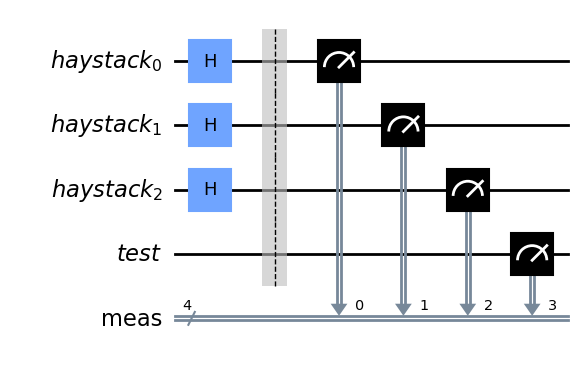

In [11]:
haystack_needle = make_haystack_needle()
haystack_needle.draw('mpl')

回路が完成したら、`qasm_simulator`で実行し、ヒストグラムをプロットしてください。

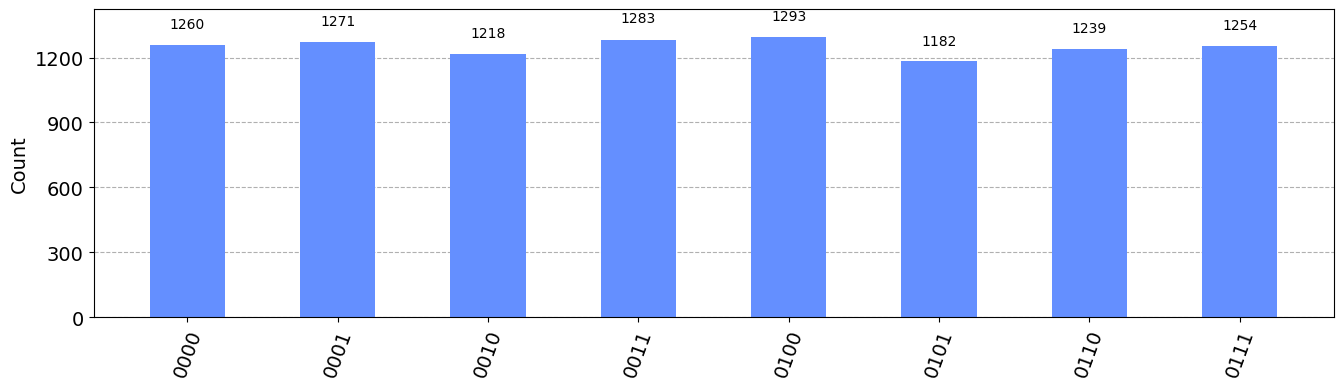

In [12]:
simulator = AerSimulator()
haystack_needle = transpile(haystack_needle, backend=simulator)
sim_job = simulator.run(haystack_needle, shots=10000)
sim_result = sim_job.result()
plot_histogram(sim_result.get_counts(), figsize=(16, 4))

**提出するもの**

- 問題1と2の完成した回路のコード（EDIT BELOWからEDIT ABOVEの部分を埋める）と得られるプロット
- 問題2で、ヒストグラムから`needle`を見つける方法の記述
- `haystack`レジスタが一般の$n$ビットであるとき、この方法で`needle`を探すことの問題点（実行時間の観点から）に関する考察
- おまけ（評価対象外）：`haystack_needle`回路を適当な実機でも実行してみる。エラーによってシミュレーションと結果が大幅に異なると予想されるが、なぜ一見単純な回路が大きく撹乱されてしまうのか？を考えてみる